In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def convert_to_npz (filename_csv, short_name_npz):
    data = np.genfromtxt(filename_csv, delimiter=',')[:,4]
    np.savez(short_name_npz, data=data)  # Save data with key 'data' in npz file

    
def load_from_npz(short_name_npz):
    loaded_data = np.load(short_name_npz)
    return loaded_data['data']
    

In [3]:
convert = False

if convert:
    convert_to_npz("data/25mhz_240611_153549.csv", "undrifted.npz")
loaded_data = load_from_npz("undrifted.npz")
    

In [74]:
def comb_plot(data):
    Ns = len(data)
    sampling_rate = 250e6
    dt = Ns/sampling_rate
    df = 1/dt

    ndx = 50e3/df
    d_ndx = 100e3/df
    coef = np.fft.rfft(data)
    freqs = np.fft.rfftfreq(Ns)
    pwr = np.abs(coef[int(ndx):int(5e6):int(d_ndx)]**2)
    avgd = []
    i = 0.905e6
    d = 1000
    while i <= 5e6:
        avgd.append(np.mean(coef[int(i-d):int(i+d)]**2))
        i += d_ndx
        
    return np.array(pwr),freqs,np.array(avgd)

In [75]:
pwrs,freqs,avgs = comb_plot(loaded_data)

[]

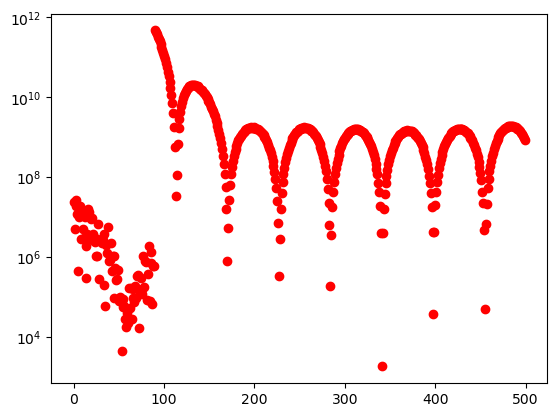

In [76]:
plt.plot(pwrs,'ro')
plt.semilogy()

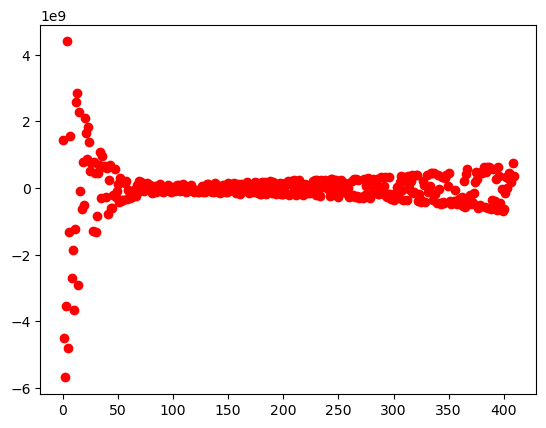

In [77]:
plt.plot(avgs,'ro')
# plt.semilogy()

(2000000.0, 2500000.0)

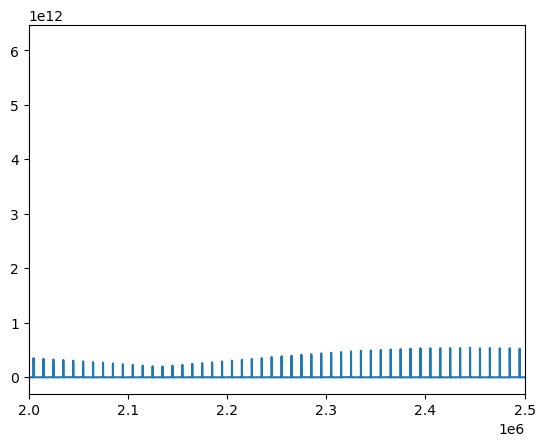

In [7]:
plt.plot(pwrs[int(1e6):int(5e6)])
plt.xlim(2e6,2.5e6) # at lowest point consistent combs are all above 1e11

In [8]:
comb = np.zeros(len(pwrs))
indices = []
for i in range(len(pwrs)):
    didx = 50
    if i+1 == len(pwrs):
        break
        
    if pwrs[i] > 1e11:
        comb[i] = pwrs[i]
        indices.append(i)
        if comb[i-1] != 0:
            peak_idx = np.argmax(pwrs[i-didx:i+didx])
            comb[peak_idx] = pwrs[peak_idx]
            comb[peak_idx - didx:peak_idx] = 0
            comb[peak_idx + 1:peak_idx + didx] = 0
        i += didx
    

comb = np.array(comb)


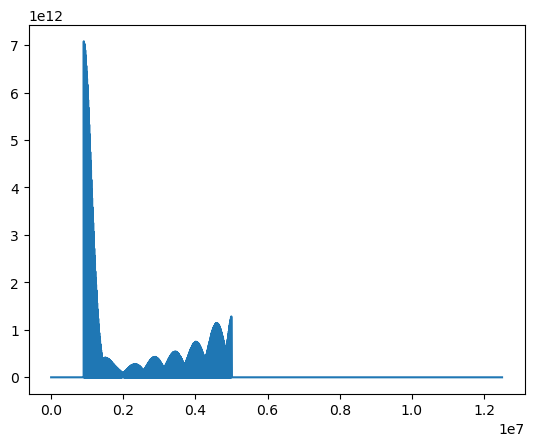

In [9]:
plt.plot(comb)

In [10]:
wave = np.fromfile('data/calibrator_231001.bin' ,dtype=np.int16)

In [11]:
pwrsog,freqsog = comb_plot(wave)

[]

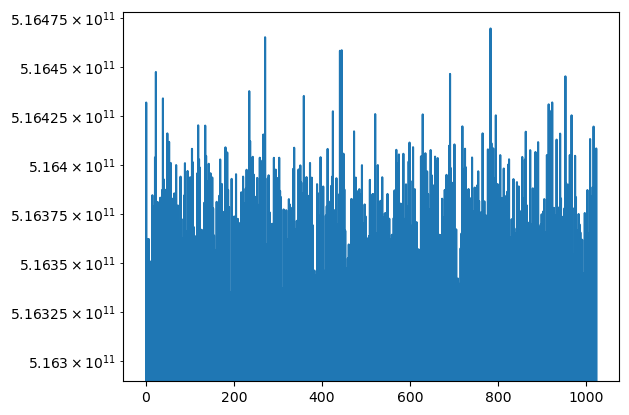

In [12]:
plt.plot(pwrsog)
# plt.xlim(50,100)
plt.semilogy()

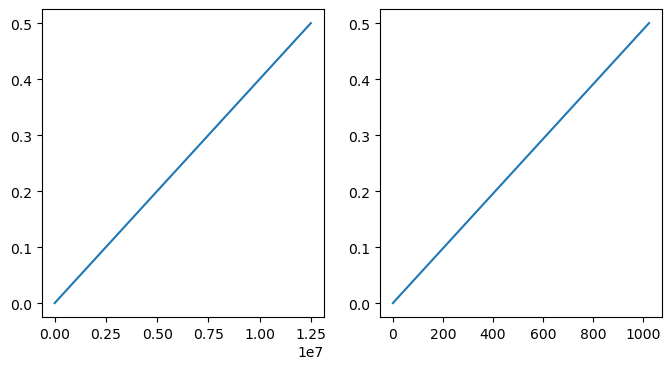

In [13]:
fig = plt.figure(figsize=(8, 4)) 
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(freqs)
ax2.plot(freqsog)